In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 6
commitnumber = d62b618
conc = 1.8e-06
dv = 0.005
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [2, 4]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 257
vmax = 1215
vmin = 1100
w_diffuse = [(1.66, 1.66), (1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1), (1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

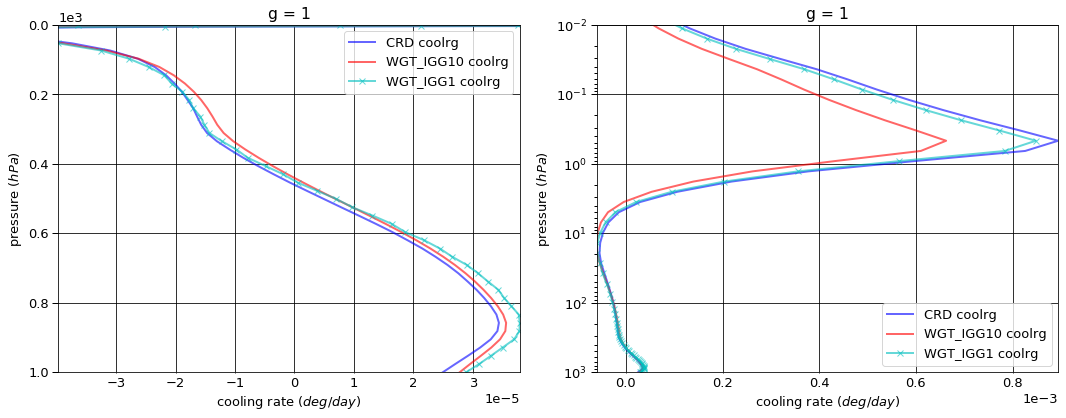

# Figure: cooling rate g-group 2

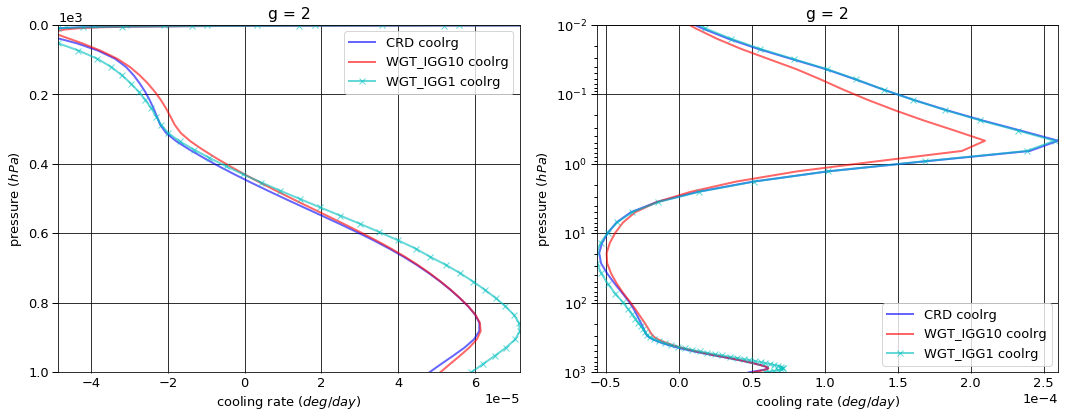

# Figure: cooling rate g-group 3

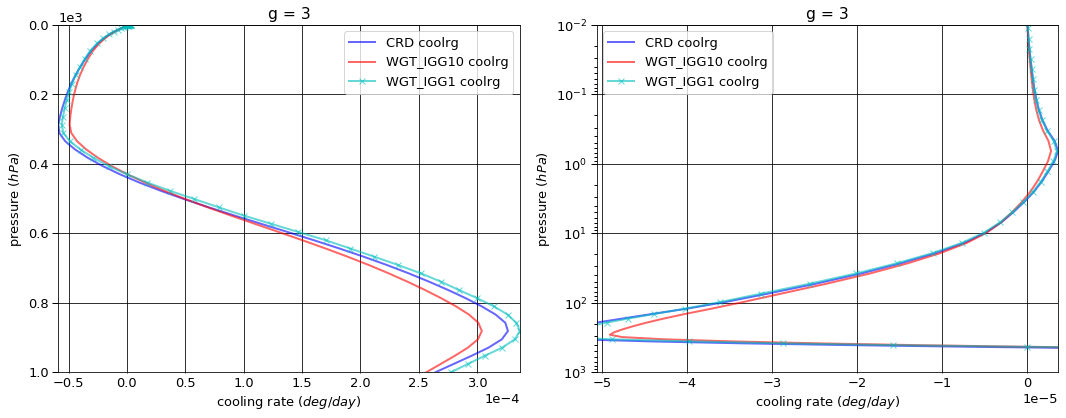

# Figure: cooling rate g-group 4

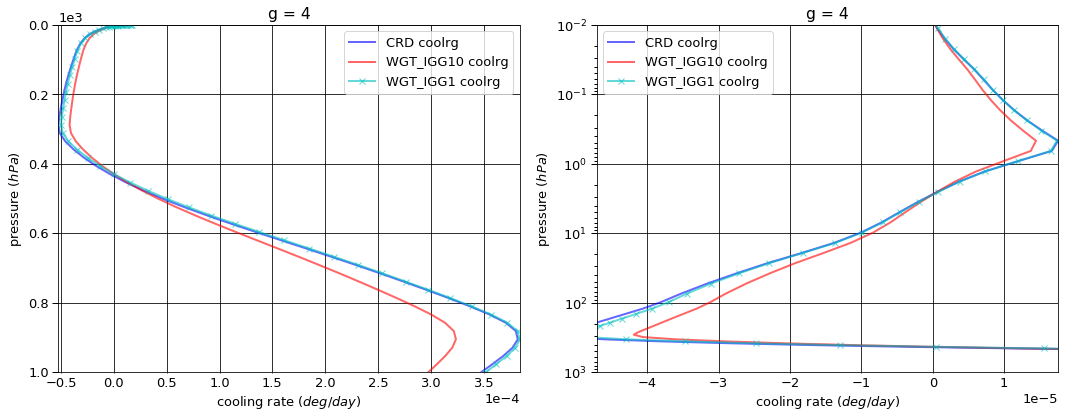

# Figure: cooling rate g-group 5

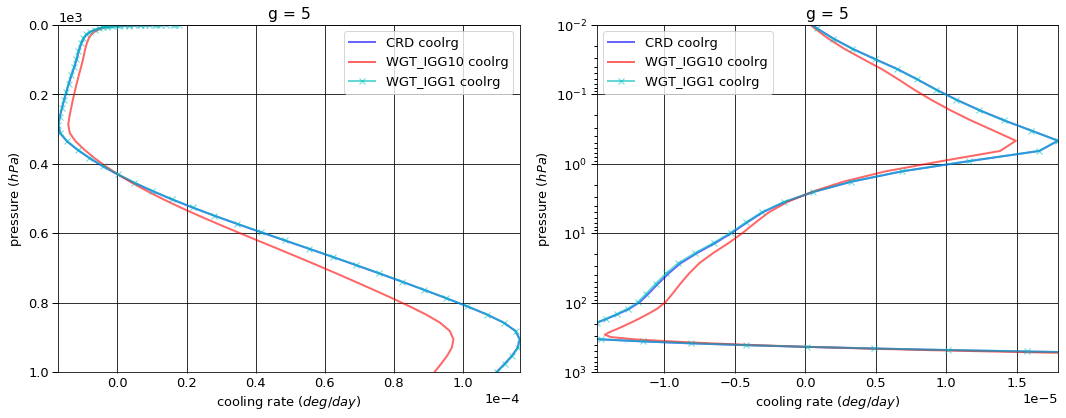

# Figure: cooling rate g-group 6

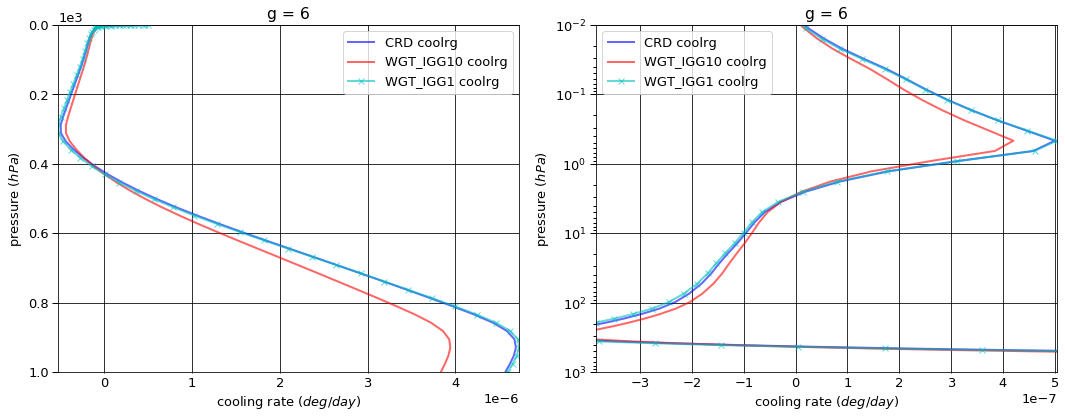

# Figure: cooling rate g-group total

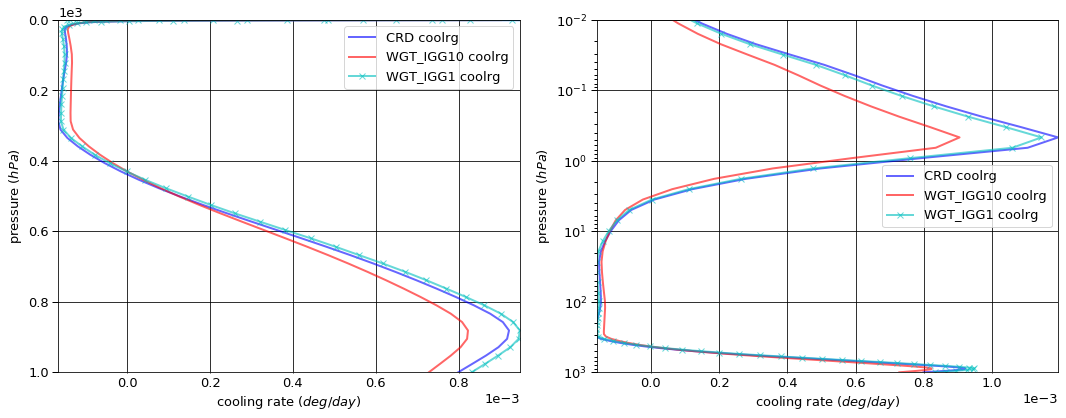

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016240  0.000000 -0.016240
  1013.0   76    -0.018448  0.002831 -0.015617
2 0.0      1     -0.192476  0.000000 -0.192476
  1013.0   76    -0.195499  0.004510 -0.190990
3 0.0      1     -0.193190  0.000000 -0.193190
  1013.0   76    -0.199755  0.018810 -0.180944
4 0.0      1     -2.017204  0.000000 -2.017204
  1013.0   76    -2.023092  0.019939 -2.003153
5 0.0      1     -5.643622  0.000000 -5.643622
  1013.0   76    -5.645496  0.006145 -5.639351
6 0.0      1     -2.214778  0.000000 -2.214778
  1013.0   76    -2.214834  0.000234 -2.214600


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016139  0.000000 -0.016139
  1013.0   76    -0.018320  0.002924 -0.015395
2 0.0      1     -0.192290  0.000000 -0.192290
  1013.0   76    -0.195008  0.004402 -0.190606
3 0.0      1     -0.192575  0.000000 -0.192575
  1013.0   76    -0.198242  0.017384 -0.180858
4 0.0      1     -2.008916  0.000000 -2.008916
  1013.0   76    -2.013750  0.016908 -1.996843
5 0.0      1     -5.643678  0.000000 -5.643678
  1013.0   76    -5.645239  0.005134 -5.640105
6 0.0      1     -2.226518  0.000000 -2.226518
  1013.0   76    -2.226565  0.000195 -2.226370


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.015962  0.000000 -0.015962
  1013.0   76    -0.018320  0.003162 -0.015158
2 0.0      1     -0.191808  0.000000 -0.191808
  1013.0   76    -0.195008  0.005156 -0.189852
3 0.0      1     -0.191694  0.000000 -0.191694
  1013.0   76    -0.198242  0.019559 -0.178683
4 0.0      1     -2.007972  0.000000 -2.007972
  1013.0   76    -2.013750  0.020120 -1.993630
5 0.0      1     -5.643368  0.000000 -5.643368
  1013.0   76    -5.645239  0.006149 -5.639089
6 0.0      1     -2.226509  0.000000 -2.226509
  1013.0   76    -2.226565  0.000234 -2.226332


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000101  0.000000  0.000101
  1013.0   76     0.000128  0.000093  0.000222
2 0.0      1      0.000187  0.000000  0.000187
  1013.0   76     0.000491 -0.000108  0.000383
3 0.0      1      0.000615  0.000000  0.000615
  1013.0   76     0.001512 -0.001426  0.000086
4 0.0      1      0.008289  0.000000  0.008289
  1013.0   76     0.009342 -0.003031  0.006311
5 0.0      1     -0.000055  0.000000 -0.000055
  1013.0   76     0.000257 -0.001011 -0.000754
6 0.0      1     -0.011740  0.000000 -0.011740
  1013.0   76    -0.011731 -0.000039 -0.011770


WGT_IGG1 - CRD


flug          fldg     fnetg
g pressure level                                  
1 0.0      1      0.000278  0.000000e+00  0.000278
  1013.0   76     0.000128  3.305819e-04  0.000459
2 0.0      1      0.000669  0.000000e+00  0.000669
  1013.0   76     0.000491  6.462994e-04  0.001137
3 0.0      1      0.001496  0.000000e+00  0.001496
  1013.0   76     0.001512  7.489150e-04  0.002261
4 0.0      1      0.009233  0.000000e+00  0.009233
  1013.0   76     0.009342  1.810260e-04  0.009523
5 0.0      1      0.000254  0.000000e+00  0.000254
  1013.0   76     0.000257  4.253700e-06  0.000262
6 0.0      1     -0.011730  0.000000e+00 -0.011730
  1013.0   76    -0.011731  1.725100e-07 -0.011731

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.945075e-05
  1001.112500 75     2.492963e-05
2 0.000312    1     -6.285798e-05
  1001.112500 75     4.810597e-05
3 0.000312    1     -2.152915e-07
  1001.112500 75     2.642588e-04
4 0.000312    1     -3.339377e-06
  1001.112500 75     3.475885e-04
5 0.000312    1     -4.040659e-06
  1001.112500 75     1.096628e-04
6 0.000312    1     -9.291307e-08
  1001.112500 75     4.566585e-06


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -8.169892e-05
  1001.112500 75     2.776436e-05
2 0.000312    1     -5.304544e-05
  1001.112500 75     5.092716e-05
3 0.000312    1     -1.840155e-07
  1001.112500 75     2.563980e-04
4 0.000312    1     -2.768035e-06
  1001.112500 75     2.976005e-04
5 0.000312    1     -3.427967e-06
  1001.112500 75     9.170965e-05
6 0.000312    1     -8.053267e-08
  1001.112500 75     3.832163e-06


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -7.738939e-05
  1001.112500 75     2.886653e-05
2 0.000312    1     -6.029415e-05
  1001.112500 75     5.901176e-05
3 0.000312    1     -2.018837e-07
  1001.112500 75     2.774579e-04
4 0.000312    1     -3.291957e-06
  1001.112500 75     3.519138e-04
5 0.000312    1     -4.105683e-06
  1001.112500 75     1.097815e-04
6 0.000312    1     -9.649150e-08
  1001.112500 75     4.593339e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.224817e-05
  1001.112500 75     2.834729e-06
2 0.000312    1      9.812545e-06
  1001.112500 75     2.821187e-06
3 0.000312    1      3.127598e-08
  1001.112500 75    -7.860730e-06
4 0.000312    1      5.713418e-07
  1001.112500 75    -4.998798e-05
5 0.000312    1      6.126919e-07
  1001.112500 75    -1.795316e-05
6 0.000312    1      1.238041e-08
  1001.112500 75    -7.344224e-07


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.938633e-06
  1001.112500 75     3.936895e-06
2 0.000312    1      2.563830e-06
  1001.112500 75     1.090579e-05
3 0.000312    1      1.340785e-08
  1001.112500 75     1.319917e-05
4 0.000312    1      4.742020e-08
  1001.112500 75     4.325360e-06
5 0.000312    1     -6.502410e-08
  1001.112500 75     1.186600e-07
6 0.000312    1     -3.578429e-09
  1001.112500 75     2.675350e-08

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.277511,0.000000,-10.277511
1013.0,76,-10.297124,0.052469,-10.244656



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.280115,0.000000,-10.280115
1013.0,76,-10.297125,0.046947,-10.250178



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.277312,0.00000,-10.277312
1013.0,76,-10.297125,0.05438,-10.242744



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.604034e-03,0.000000,-0.002604
1013.0,76,-7.800000e-08,-0.005522,-0.005522



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.993430e-04,0.000000,0.000199
1013.0,76,-7.800000e-08,0.001911,0.001911


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000140
1001.112500,75,0.000799



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000141
1001.112500,75,0.000728



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000145
1001.112500,75,0.000832



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,-0.000071



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000005
1001.112500,75,0.000033


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.002043,0.001779
2,0.019913,0.018938
3,0.022391,0.019252
4,0.214348,0.195564
5,0.547870,0.548234
6,0.193435,0.216232


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.000576e-20
2,3.469895e-22
3,9.290698e-22
4,5.931843e-23
5,3.787311e-24
6,2.418089e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.000576e-20,NaN,0.002043,0.001779,0.002043,0.001779,1.0
2,3.469895e-22,0.034679,0.019913,0.018938,0.021957,0.020717,1.0
3,9.290698e-22,2.677516,0.022391,0.019252,0.044348,0.039969,500.0
4,5.931843e-23,0.063847,0.214348,0.195564,0.258696,0.235534,500.0
5,3.787311e-24,0.063847,0.547870,0.548234,0.806565,0.783768,500.0
6,2.418089e-25,0.063847,0.193435,0.216232,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
